In this project we explore the neighborhoods of top 1000 World's Universities, and try to find out what they have in common and in what way they differ from each other. The data that we have saved in the csv files is the following: 

1. The list of Top 1000 Universities and their geographic location. (To create this file I used the Google API geocoder...)
2. The list of all places found in the neighborhoods of the top Universities (To find them all I used Foursquare...)

Using this data, we will cluster the universities using the KMeans Algorithm, then we will visualize this clustering on a folium map and then, we will look at the most popular places in the neighborhoods of Universities that got into the same cluster to find out what they do have in common. 

Now let us import the libraries that we will need. 

In [1]:
#importing all libraries we will use
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import ssl
import re
import json # library to handle JSON files
#!conda install -c conda-forge geotext --yes
from geotext import GeoText

import googlemaps
from datetime import datetime

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="uni_expl")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


The each row of first table we will work with contains the following data: 
1. Name of University
2. Rank
3. Country
4. its Latitude/Longitude
5. rank cluster (Rank/100)


In [2]:
gdf=pd.read_csv('GEOCLUSTER.csv')
gdf.drop(columns='Unnamed: 0',inplace=True)
gdf.dropna(inplace=True)
gdf.head()

,University,rank,Country,Latitude,Longitude,rank cluster
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),1,United States,42.360091,-71.094160,0
1,STANFORD UNIVERSITY,2,United States,37.427475,-122.169719,0
2,HARVARD UNIVERSITY,3,United States,42.377003,-71.116660,0
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),4,United States,34.137658,-118.125269,0
4,UNIVERSITY OF OXFORD,5,United Kingdom,51.754816,-1.254367,0


The second table contains the information about the venues found in the neighborhoods of Universities: 
1. University
2. Latitude/Longitude of University
3. Venue
4. Geolocation of the Venue
5. Category of the Venue

In [3]:
venues=pd.read_csv('UNIVENUES.csv')
venues.drop(columns='Unnamed: 0',inplace=True)
venues.dropna(inplace=True)
venues.head()

,University,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Zesiger Sports And Fitness Center,42.358802,-71.095888,Gym / Fitness Center
1,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Flour Bakery + Cafe,42.361123,-71.096521,Bakery
2,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Central Bottle Wine + Provisions,42.361246,-71.096741,Wine Shop
3,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,MIT Johnson Athletics Center (Building W34),42.358856,-71.095932,College Gym
4,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),42.360091,-71.09416,Cafe Luna,42.362875,-71.094341,Café


Now let us group the venues table by university and see how many venue categories we have encountered.

In [4]:
venues.groupby('University').count().head()

,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
University,,,,,,
AALBORG UNIVERSITY,4,4,4,4,4,4
AALTO UNIVERSITY,25,25,25,25,25,25
AARHUS UNIVERSITY,7,7,7,7,7,7
ABERYSTWYTH UNIVERSITY,4,4,4,4,4,4
ABO AKADEMI UNIVERSITY,74,74,74,74,74,74


In [5]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 631 unique categories.


To switch to numerical data that we will work with, let us make a onehot encoding of the venues table. 

In [6]:
# one hot encoding
uni_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uni_onehot['University'] = venues['University'] 

# move neighborhood column to the first column
fixed_columns = [uni_onehot.columns[-1]] + list(uni_onehot.columns[:-1])
uni_onehot = uni_onehot[fixed_columns]

uni_onehot.shape

(33271, 631)

Now we use the Standard Scaler before we start to work with our data. 

In [7]:
uni_grouped = uni_onehot.groupby('University').mean().reset_index()
X=uni_grouped.drop('University', 1)
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
data=X_std
dataframe=pd.DataFrame(data)
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,620,621,622,623,624,625,626,627,628,629
0,-0.031814,-0.08857,-0.043226,-0.103224,-0.062736,-0.061392,-0.031814,-0.031814,-0.241323,-0.053557,...,-0.195573,-0.040696,-0.126703,-0.152799,-0.046352,-0.071977,-0.138043,-0.050911,-0.031814,-0.063919
1,-0.031814,-0.08857,-0.043226,-0.103224,-0.062736,-0.061392,-0.031814,-0.031814,-0.241323,-0.053557,...,-0.195573,-0.040696,-0.126703,-0.152799,-0.046352,-0.071977,-0.138043,-0.050911,-0.031814,-0.063919
2,-0.031814,-0.08857,-0.043226,-0.103224,-0.062736,-0.061392,-0.031814,-0.031814,-0.241323,-0.053557,...,-0.195573,-0.040696,-0.126703,-0.152799,-0.046352,-0.071977,-0.138043,-0.050911,-0.031814,-0.063919
3,-0.031814,-0.08857,-0.043226,-0.103224,-0.062736,-0.061392,-0.031814,-0.031814,-0.241323,-0.053557,...,-0.195573,-0.040696,-0.126703,-0.152799,-0.046352,-0.071977,-0.138043,-0.050911,-0.031814,-0.063919
4,-0.031814,-0.08857,-0.043226,-0.103224,-0.062736,-0.061392,-0.031814,-0.031814,-0.241323,-0.053557,...,-0.195573,-0.040696,-0.126703,-0.152799,-0.046352,-0.071977,-0.138043,-0.050911,-0.031814,-0.063919


Now let us use the elbow method to find the optimal number of clusters. This number is 7.


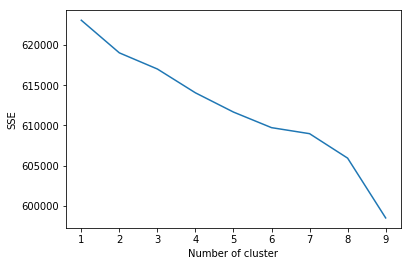

In [8]:
uni_grouped_clustering = dataframe
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=4).fit(uni_grouped_clustering)
    uni_grouped_clustering["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Now we produce the clustering.

In [9]:
# set number of clusters
kclusters = 7

uni_grouped_clustering = uni_grouped.drop('University', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(uni_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 1, 2, 1, 2, 1, 4, 2, 6])

Let us extract the top 10 common places in each of the neighborhoods.

In [10]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [11]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['University']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
uni_venues_sorted = pd.DataFrame(columns=columns)
uni_venues_sorted['University'] = uni_grouped['University']

for ind in np.arange(uni_grouped.shape[0]):
    uni_venues_sorted.iloc[ind, 1:] = return_most_common_venues(uni_grouped.iloc[ind, :], num_top_venues)

uni_venues_sorted.head()


,University,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AALBORG UNIVERSITY,Gym,Bus Station,Zoo,Fabric Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
1,AALTO UNIVERSITY,Cafeteria,Recreation Center,Bus Stop,Waterfront,Sandwich Place,Event Space,Coffee Shop,Pier,Metro Station,Hotel
2,AARHUS UNIVERSITY,Science Museum,Bar,Park,Student Center,Eye Doctor,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm
3,ABERYSTWYTH UNIVERSITY,Movie Theater,College Quad,Pharmacy,Coffee Shop,Zoo,Fabric Shop,Field,Fast Food Restaurant,Farmers Market,Farm
4,ABO AKADEMI UNIVERSITY,Café,Bar,Restaurant,Scandinavian Restaurant,Gym,Wine Bar,Italian Restaurant,History Museum,Museum,Pub


Now let us add the cluster labels we produced earlier into the table containing top 10 common places.

In [12]:
# add clustering labels
uni_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
uni_merged = gdf


uni_merged = uni_merged.join(uni_venues_sorted.set_index('University'), on='University')

uni_merged.head() # check the last columns!

,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),1,United States,42.360091,-71.094160,0,4.0,Lounge,Coffee Shop,Rental Car Location,Pizza Place,Sandwich Place,College Gym,Pub,New American Restaurant,Italian Restaurant,Burrito Place
1,STANFORD UNIVERSITY,2,United States,37.427475,-122.169719,0,2.0,Coffee Shop,Café,Fountain,Sculpture Garden,Sandwich Place,Monument / Landmark,Food Truck,Outdoor Sculpture,Grocery Store,Chinese Restaurant
2,HARVARD UNIVERSITY,3,United States,42.377003,-71.116660,0,4.0,Bookstore,Café,Pizza Place,Ice Cream Shop,Gastropub,Mexican Restaurant,Boutique,American Restaurant,Burger Joint,Coffee Shop
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),4,United States,34.137658,-118.125269,0,4.0,Theater,Café,Park,Scenic Lookout,Hotel,Gym,Gym / Fitness Center,Coffee Shop,Pool,Food & Drink Shop
4,UNIVERSITY OF OXFORD,5,United Kingdom,51.754816,-1.254367,0,1.0,Pub,Coffee Shop,Café,Thai Restaurant,Sandwich Place,Burger Joint,Bookstore,History Museum,Hotel,Art Gallery


In [13]:
uni_merged.dropna(inplace=True)

Now we visualize the clustering on a map.

In [14]:
# create map
map_clusters = folium.Map(location=[46.199444,6.142927], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(uni_merged['Latitude'], uni_merged['Longitude'], uni_merged['University'], uni_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now let us look at each of the clusters.

Here is the first cluster, which contains mostly Asian (namely Chinese) Universities. The neighborhoods have a strong eastern influence, asian and oriental cuisine present, lots of farms nearby.

In [15]:
uni_merged.loc[uni_merged['Cluster Labels'] == 0.0].head()


,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,TSINGHUA UNIVERSITY,17,China,39.999667,116.326444,0,0.0,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Chinese Restaurant,Xinjiang Restaurant,Café,Performing Arts Venue,Fabric Shop,Field,Farmers Market,Farm
29,PEKING UNIVERSITY,30,China,39.986913,116.305874,0,0.0,Chinese Restaurant,Fast Food Restaurant,Café,Gym,College Cafeteria,Noodle House,Metro Station,Hardware Store,Zoo,Farmers Market
262,INDIAN INSTITUTE OF TECHNOLOGY MADRAS (IITM),264,India,12.991493,80.233691,2,0.0,Theater,Indian Restaurant,Fast Food Restaurant,Bus Station,Cafeteria,Zoo,Fabric Shop,Field,Farmers Market,Farm
290,BEIJING NORMAL UNIVERSITY,292,China,39.961954,116.366261,2,0.0,Fast Food Restaurant,Park,Pizza Place,Hotel,Zoo,Exhibit,Farmers Market,Farm,Falafel Restaurant,Fabric Shop
294,SUN YAT-SEN UNIVERSITY,295,China,23.096538,113.298883,2,0.0,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Metro Station,Zoo,Eye Doctor,Field,Farmers Market,Farm,Falafel Restaurant


A lot of European universities in the cluster, the neighborhoods really look like neighborhoods of a typical European University.

In [16]:
uni_merged.loc[uni_merged['Cluster Labels'] == 1.0].head()

,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,UNIVERSITY OF OXFORD,5,United Kingdom,51.754816,-1.254367,0,1.0,Pub,Coffee Shop,Café,Thai Restaurant,Sandwich Place,Burger Joint,Bookstore,History Museum,Hotel,Art Gallery
5,UNIVERSITY OF CAMBRIDGE,6,United Kingdom,52.204267,0.114908,0,1.0,Café,Coffee Shop,Pub,Clothing Store,Burger Joint,Sushi Restaurant,Bar,Sandwich Place,Bookstore,Park
6,ETH ZURICH (SWISS FEDERAL INSTITUTE OF TECHNOL...,7,Switzerland,47.376313,8.547670,0,1.0,Hotel,Swiss Restaurant,Restaurant,Bar,Café,Italian Restaurant,Coffee Shop,Tram Station,Sandwich Place,Bakery
7,IMPERIAL COLLEGE LONDON,8,United Kingdom,51.498800,-0.174877,0,1.0,Café,Hotel,Science Museum,Exhibit,Italian Restaurant,Garden,Ice Cream Shop,Gift Shop,Bakery,Coffee Shop
17,UNIVERSITY OF EDINBURGH,18,United Kingdom,55.944516,-3.189241,0,1.0,Pub,Coffee Shop,Café,Bar,Indian Restaurant,Museum,Restaurant,Pizza Place,Plaza,Seafood Restaurant


Next cluster: a lot of food and a lot of things to do, including sportrs and quite a bit of arts.

In [17]:
uni_merged.loc[uni_merged['Cluster Labels'] == 2.0].head()

,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,STANFORD UNIVERSITY,2,United States,37.427475,-122.169719,0,2.0,Coffee Shop,Café,Fountain,Sculpture Garden,Sandwich Place,Monument / Landmark,Food Truck,Outdoor Sculpture,Grocery Store,Chinese Restaurant
27,UNIVERSITY OF TORONTO,28,Canada,43.662892,-79.395656,0,2.0,Coffee Shop,Café,Bookstore,Park,Salad Place,Tea Room,Falafel Restaurant,College Gym,Music School,Mediterranean Restaurant
34,SEOUL NATIONAL UNIVERSITY (SNU),36,South Korea,37.459882,126.951905,0,2.0,Coffee Shop,Café,Korean Restaurant,Bus Stop,Fried Chicken Joint,Bookstore,Plaza,Asian Restaurant,College Cafeteria,Bakery
38,KAIST - KOREA ADVANCED INSTITUTE OF SCIENCE AN...,40,South Korea,36.372143,127.360390,0,2.0,Coffee Shop,Convenience Store,Bakery,Café,Pharmacy,Juice Bar,Pizza Place,Donut Shop,Fast Food Restaurant,Farmers Market
42,FUDAN UNIVERSITY,44,China,31.297420,121.503618,0,2.0,Coffee Shop,Chinese Restaurant,Café,Fast Food Restaurant,Convenience Store,Sushi Restaurant,Noodle House,Mexican Restaurant,Nightclub,Italian Restaurant


Even more sports, a lot of fastfood around.

In [18]:
uni_merged.loc[uni_merged['Cluster Labels'] == 3.0].head()

,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,NANYANG TECHNOLOGICAL UNIVERSITY (NTU),12,Singapore,1.348310,103.683135,0,3.0,Coffee Shop,College Cafeteria,Fast Food Restaurant,Bus Station,Indonesian Restaurant,Soup Place,Sandwich Place,Food Court,Athletics & Sports,Ethiopian Restaurant
25,DUKE UNIVERSITY,26,United States,36.001426,-78.938229,0,3.0,College Cafeteria,Fast Food Restaurant,College Theater,Coffee Shop,Museum,Plaza,College Auditorium,Bakery,Bank,Café
51,UNIVERSITY OF WISCONSIN-MADISON,53,United States,43.076592,-89.412487,0,3.0,College Cafeteria,Café,Tennis Court,American Restaurant,Scenic Lookout,Asian Restaurant,Sandwich Place,Bar,Sporting Goods Shop,General College & University
58,SHANGHAI JIAO TONG UNIVERSITY,59,China,31.025220,121.433778,0,3.0,College Cafeteria,Convenience Store,Coffee Shop,Fabric Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
110,TECHNICAL UNIVERSITY OF DENMARK,112,Denmark,55.785574,12.521381,1,3.0,Gym / Fitness Center,College Cafeteria,Bar,Food & Drink Shop,Zoo,Fabric Shop,Field,Fast Food Restaurant,Farmers Market,Farm


In [20]:
uni_merged.loc[uni_merged['Cluster Labels'] == 4.0].head()

,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY (MIT),1,United States,42.360091,-71.094160,0,4.0,Lounge,Coffee Shop,Rental Car Location,Pizza Place,Sandwich Place,College Gym,Pub,New American Restaurant,Italian Restaurant,Burrito Place
2,HARVARD UNIVERSITY,3,United States,42.377003,-71.116660,0,4.0,Bookstore,Café,Pizza Place,Ice Cream Shop,Gastropub,Mexican Restaurant,Boutique,American Restaurant,Burger Joint,Coffee Shop
3,CALIFORNIA INSTITUTE OF TECHNOLOGY (CALTECH),4,United States,34.137658,-118.125269,0,4.0,Theater,Café,Park,Scenic Lookout,Hotel,Gym,Gym / Fitness Center,Coffee Shop,Pool,Food & Drink Shop
8,UNIVERSITY OF CHICAGO,9,United States,41.788608,-87.598713,0,4.0,Coffee Shop,Café,Sandwich Place,Bookstore,College Cafeteria,History Museum,Student Center,Art Museum,Park,Bakery
9,UCL (UNIVERSITY COLLEGE LONDON),10,United Kingdom,51.524275,-0.133360,0,4.0,Coffee Shop,Café,Pizza Place,Furniture / Home Store,Theater,Turkish Restaurant,Plaza,Beer Bar,Bookstore,Bakery


Mostly food around, surprisingly many Australian universities here. Universities might be a bit isolated here.

In [21]:
uni_merged.loc[uni_merged['Cluster Labels'] == 5.0].head()

,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,ÉCOLE POLYTECHNIQUE FÉDÉRALE DE LAUSANNE (EPFL),22,Switzerland,46.519056,6.566758,0,5.0,Café,Hotel,Burger Joint,Bar,Bookstore,Sandwich Place,Light Rail Station,Italian Restaurant,Discount Store,Supermarket
23,AUSTRALIAN NATIONAL UNIVERSITY (ANU),24,Australia,-35.277700,149.118527,0,5.0,Café,Food Truck,Concert Hall,Coffee Shop,Plaza,Grocery Store,Dim Sum Restaurant,Indian Restaurant,Sandwich Place,Science Museum
37,THE UNIVERSITY OF MELBOURNE,39,Australia,-37.798346,144.960974,0,5.0,Café,Coffee Shop,Italian Restaurant,Burger Joint,Thai Restaurant,Convenience Store,Deli / Bodega,Japanese Restaurant,Bar,Lounge
40,THE UNIVERSITY OF SYDNEY,42,Australia,-33.888584,151.187347,0,5.0,Café,Thai Restaurant,Australian Restaurant,Pizza Place,Library,College Rec Center,Vegetarian / Vegan Restaurant,Used Bookstore,Paper / Office Supplies Store,Park
57,MONASH UNIVERSITY,59,Australia,-37.910524,145.136218,0,5.0,Café,Bar,Vegetarian / Vegan Restaurant,Pool,Asian Restaurant,Bowling Green,Grocery Store,Park,Juice Bar,Concert Hall


Another Cluster with Asian taste: now influenced mostly by Japan.

In [22]:
uni_merged.loc[uni_merged['Cluster Labels'] == 6.0].head()

,University,rank,Country,Latitude,Longitude,rank cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,CORNELL UNIVERSITY,14,United States,42.453449,-76.473503,0,6.0,Tourist Information Center,Convenience Store,College Gym,Scenic Lookout,Garden,Lake,Bowling Alley,Volleyball Court,Café,Farm
22,THE UNIVERSITY OF TOKYO,23,Japan,35.712678,139.761989,0,6.0,Convenience Store,Café,Coffee Shop,Ramen Restaurant,Historic Site,Hotel,Plaza,Japanese Restaurant,Japanese Curry Restaurant,Steakhouse
33,KYOTO UNIVERSITY,35,Japan,35.026244,135.780822,0,6.0,Convenience Store,Café,Japanese Restaurant,Bar,Yoshoku Restaurant,Chinese Restaurant,Wagashi Place,Ramen Restaurant,Indian Restaurant,Asian Restaurant
55,UNIVERSITY OF AMSTERDAM,57,Netherlands,52.355818,4.955726,0,6.0,Convenience Store,Café,Coffee Shop,Playground,Train Station,Restaurant,Frame Store,Fast Food Restaurant,Farm,Falafel Restaurant
56,TOKYO INSTITUTE OF TECHNOLOGY,58,Japan,35.605123,139.683530,0,6.0,Convenience Store,Ramen Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Grocery Store,Train Station,Coffee Shop,Italian Restaurant,Steakhouse


As we see, there is no evident connection between the facilities offered by the neighborhoods and the university ranking, but at the same time, it is nice to look into the patterns the KMeans clustering gives.